In [1]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf,plot_predict
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit

In [2]:
df1 = pd.read_csv('tiobeindex2.csv')

tiobe_languages = list(df1.columns)
tiobe_languages.remove('Month')

df=df1['Python']

In [3]:
model = pm.auto_arima(df, seasonal=False, stepwise=True, trace=True)

print(f"Best p: {model.order[0]}")
print(f"Best d: {model.order[1]}")
print(f"Best q: {model.order[2]}")

p = model.order[0]
d = model.order[1]
q = model.order[2]

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=544.288, Time=2.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=544.457, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=542.831, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=542.759, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=546.206, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=544.758, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=544.758, Time=0.92 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=544.185, Time=2.61 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=543.833, Time=0.33 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 7.602 seconds
Best p: 0
Best d: 1
Best q: 1


In [4]:
df = df.dropna()
df = df.astype(float)

arima_model = ARIMA(df, order=(p,d,q))
model = arima_model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                 Python   No. Observations:                  281
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -269.916
Date:                Mon, 25 Nov 2024   AIC                            543.833
Time:                        17:35:24   BIC                            551.102
Sample:                             0   HQIC                           546.748
                                - 281                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1256      0.041      3.084      0.002       0.046       0.205
sigma2         0.4025      0.020     20.289      0.000       0.364       0.441
Ljung-Box (L1) (Q):                   0.02   Jarque-

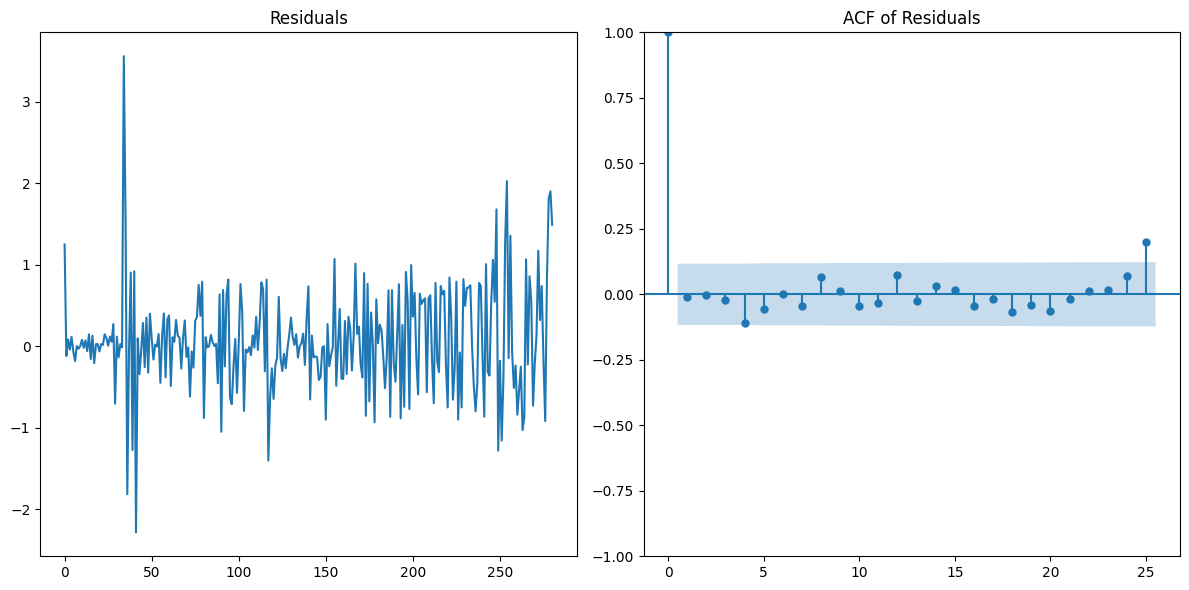

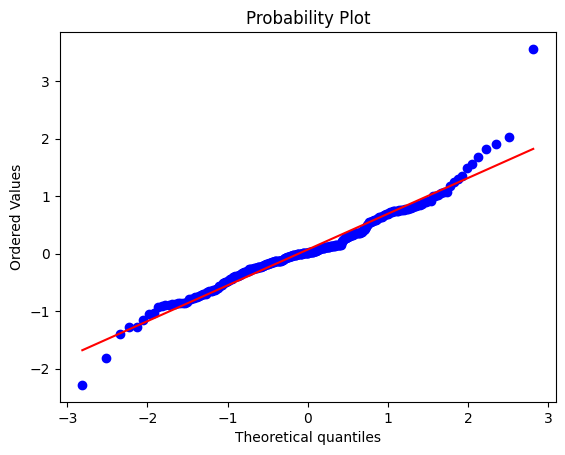

In [5]:
residuals = model.resid
plt.figure(figsize=(12, 6))

# Residual plot
plt.subplot(1, 2, 1)
plt.plot(residuals)
plt.title('Residuals')

# ACF of residuals
plt.subplot(1, 2, 2)
plot_acf(residuals, ax=plt.gca())
plt.title('ACF of Residuals')

plt.tight_layout()
plt.show()

# Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.show()


In [6]:
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

arima_model = ARIMA(train, order=(1,1,1))
model = arima_model.fit()

forecast = model.forecast(steps=len(test))

mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}")


MAE: 4.05913138182325, MSE: 23.516022108146732, RMSE: 4.849332130113046


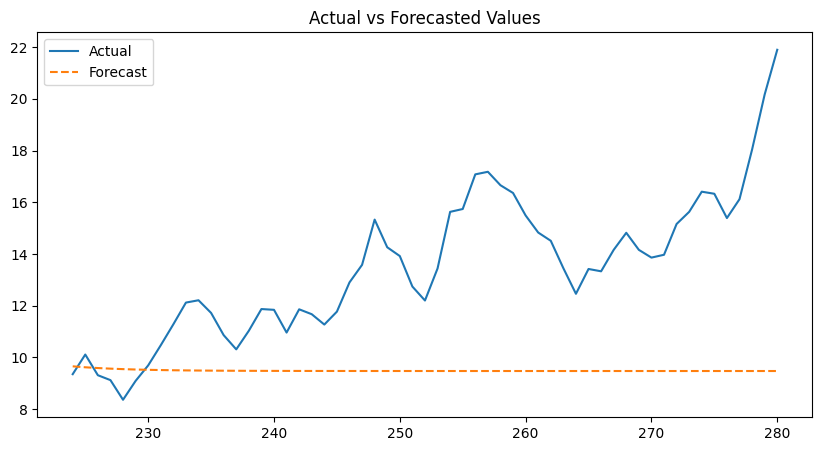

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Forecast', linestyle='--')
plt.legend()
plt.title("Actual vs Forecasted Values")
plt.show()


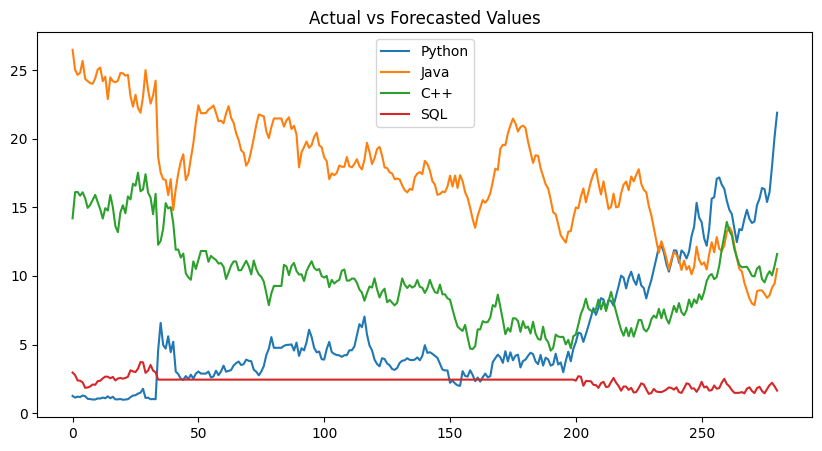

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(df1['Month'].index, df1['Month'], label='Python')
plt.plot(df1['Python'].index, df1['Python'], label='Python')
plt.plot(df1['Java'].index, df1['Java'], label='Java')
plt.plot(df1['C++'].index, df1['C++'], label='C++')
plt.plot(df1['SQL'].index, df1['SQL'], label='SQL')
plt.legend()
plt.title("Actual vs Forecasted Values")
plt.show()


In [ ]:
di = {}
di['language'] = []
di['mae'] = []
di['mse'] = []
di['rmse'] = []


for language in tiobe_languages:
    df = df1[language]

    tscv = TimeSeriesSplit(n_splits=10)
    
    fold_mae = []
    fold_mse = []
    fold_rmse = []

    for train_index, test_index in tscv.split(df):
        train, test = df.iloc[train_index], df.iloc[test_index]
        
        model = pm.auto_arima(train, seasonal=False, stepwise=True, trace=False)
        p, d, q = model.order
        
        arima_model = ARIMA(train, order=(p, d, q))
        model = arima_model.fit()

        forecast = model.forecast(steps=len(test))

        mae = mean_absolute_error(test, forecast)
        mse = mean_squared_error(test, forecast)
        rmse = np.sqrt(mse)

        fold_mae.append(mae)
        fold_mse.append(mse)
        fold_rmse.append(rmse)

    avg_mae = np.mean(fold_mae)
    avg_mse = np.mean(fold_mse)
    avg_rmse = np.mean(fold_rmse)

    print(f'Language: {language}')
    print(f"Average MAE: {avg_mae}, Average MSE: {avg_mse}, Average RMSE: {avg_rmse}")
    print()

    di['language'].append(language)
    di['mae'].append(avg_mae)
    di['mse'].append(avg_mse)
    di['rmse'].append(avg_rmse)

df_res = pd.DataFrame.from_dict(di)
df_res.to_csv('result_arima.csv', index=False)